In [1]:
import torch
from torch.utils.data import Dataset, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0")

In [2]:
import os
import csv
from PIL import Image

In [3]:
train_folder = 'C:/Users/Николай/Desktop/CernProject/data'

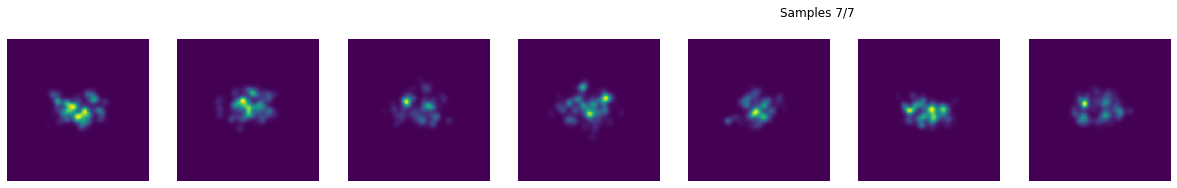

In [5]:
class CernDataset(Dataset):
    def __init__(self, folder):
        self.root_dir = folder
        self.paths = []
        
        for idx in os.listdir(folder):
            for jobresult in os.listdir(f'{folder}/{idx}'):
                if (os.path.exists(f'{folder}/{idx}/{jobresult}/printing_VISHNew/results/snapshot_Ed.dat') and
                        os.path.getsize(f'{folder}/{idx}/{jobresult}/printing_VISHNew/results/snapshot_Ed.dat') // 1048576 > 9):
                    self.paths.append(f'{idx}/{jobresult}')
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        sample_name = self.paths[index]
        sample_path = os.path.join(self.root_dir, sample_name)
        
        img = np.array([], dtype=np.float32)
        y = np.array([], dtype=np.float32)
        with open(f'{sample_path}/printing_VISHNew/results/snapshot_Ed.dat')as f:
            for idx, line in enumerate(f):
                if idx  > 262 and idx < 262 * 2:
                    t = np.fromstring(" ".join(line.split()), sep = ' ', dtype=np.float16)
                    img = np.hstack((img, t))
                if idx > 262 * 2 and idx < 262 * 3:
                    t = np.fromstring(" ".join(line.split()), sep = ' ', dtype=np.float16)
                    y = np.hstack((y, t))
        y_t = torch.from_numpy(y.reshape((1, 261, -1)))
        img_t = torch.from_numpy(img.reshape((1, 261, -1)))
        y_t = y_t[:, 3:-2, 3:-2]
        img_t = img_t[:, 3:-2, 3:-2]
        
        return img_t, y_t
    
def visualize_samples(dataset, indices, title=None, count=10):
    plt.figure(figsize=(count*3, 3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))
    for i, index in enumerate(display_indices):
        x, y = dataset[index]
        plt.subplot(1, count, i + 1)
        plt.imshow(x.squeeze())
        plt.grid(False)
        plt.axis('off')
        
        
dataset = CernDataset(train_folder)
indices = np.random.choice(np.arange(len(dataset)), 7, replace=False)

visualize_samples(dataset, indices, "Samples")

In [6]:
batch_size = 2

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)


In [7]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, lr_scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value.item()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_loss = compute_loss(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(float(val_loss))
        
        if lr_scheduler:
            lr_scheduler.step()
        
        print("Average loss: %f, Train accuracy: %f, Val loss: %f" % (ave_loss, train_accuracy, val_loss))
        
    return loss_history, train_history, val_history
        
def compute_loss(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    loss_accum = 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        loss_value = loss(prediction, y_gpu)
        loss_accum += loss_value.item()

    ave_loss = loss_accum / i_step
    return ave_loss

In [8]:
from model import Unet
import torch.optim as optim

def unet_loss(output, target):
    loss = 0.5 * torch.sum(torch.abs(output - target)) / torch.sum(torch.abs(target))
    return loss
        
model = Unet()

#model.type(torch.cuda.DoubleTensor)
model.to(device)

loss = unet_loss
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.101497, Train accuracy: 46461.143219, Val accuracy: 46461.143219
Average loss: 0.034904, Train accuracy: 46461.143219, Val accuracy: 46461.143219
Average loss: 0.029004, Train accuracy: 46461.143219, Val accuracy: 46461.143219
Average loss: 0.026218, Train accuracy: 46461.143219, Val accuracy: 46461.143219
Average loss: 0.023913, Train accuracy: 46461.143219, Val accuracy: 46461.143219


In [9]:
torch.save(model, '../models/unet_sgd_5ep.pth')

# Visuailizing model

In [5]:
model = torch.load('../models/unet_sgd_5ep.pth')
model.to(device);

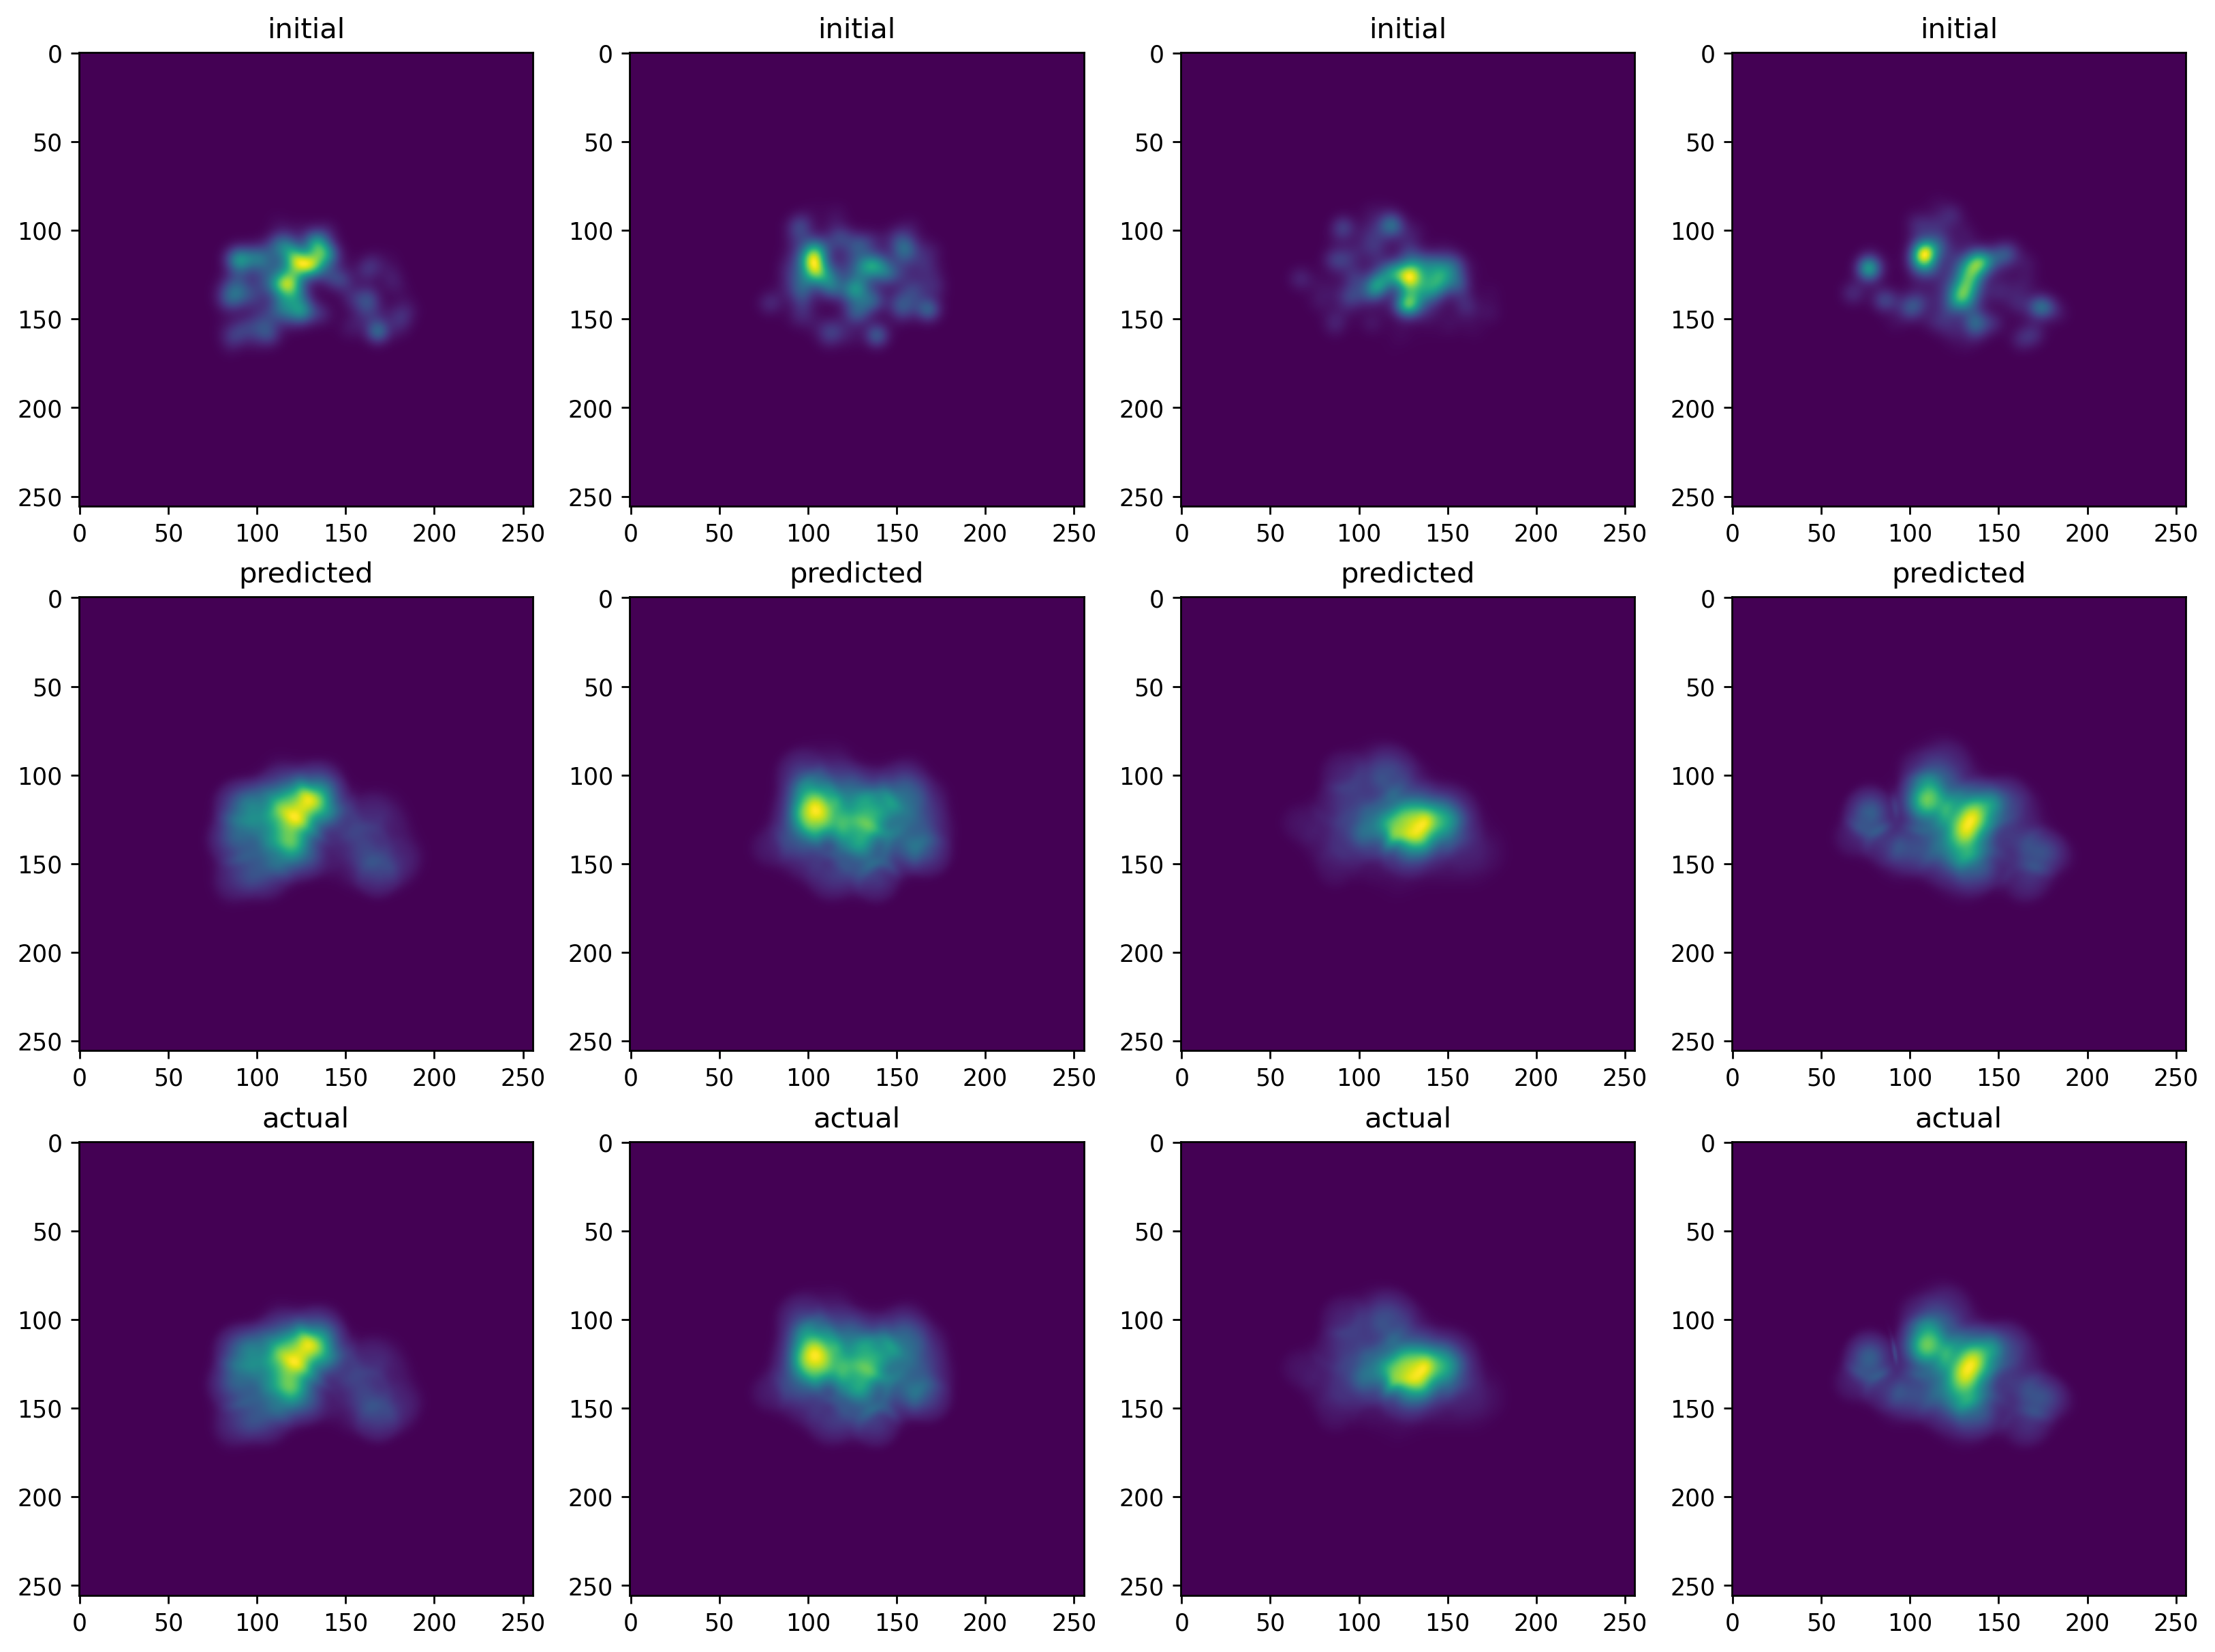

In [9]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

def visualize_model(model, dataset, title=None, count=5):
    model.eval()
    
    indices = list(range(count))
    
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset,
                                         sampler=sampler)
    fig = plt.figure(figsize=(16,12), dpi=250)
    fig.tight_layout()
    for counter, (x, y) in enumerate(loader):
        if counter > count:
            return
        x_gpu = x.to(device)
        prediction_gpu = model(x_gpu)
        prediction = prediction_gpu.cpu().detach()
        fig.add_subplot(3, count, counter + 1)
        plt.title("initial")
        plt.imshow(torch.squeeze(x))
        fig.add_subplot(3, count, counter + count + 1)
        plt.title("predicted")
        plt.imshow(torch.squeeze(prediction))
        fig.add_subplot(3, count, counter + 2 * count + 1)
        plt.title("actual")
        plt.imshow(torch.squeeze(y))
    plt.savefig('../plots/unet_adam_5ep.png')
        

visualize_model(model, dataset, count=4)

# Попробуем обучить с батчами между слоями

они будут захардкожены в model.py

In [8]:
from model import Unet
import torch.optim as optim

def unet_loss(output, target):
    loss = 0.5 * torch.sum(torch.abs(output - target)) / torch.sum(torch.abs(target))
    return loss

model = Unet()

model.to(device)

loss = unet_loss
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

Average loss: 0.086835, Train accuracy: 46461.143219, Val accuracy: 46461.143219
Average loss: 0.068930, Train accuracy: 46461.143219, Val accuracy: 46461.143219


# Без батчей, но с Adam

In [15]:
from model import Unet
import torch.optim as optim

def unet_loss(output, target):
    loss = 0.5 * torch.sum(torch.abs(output - target)) / torch.sum(torch.abs(target))
    return loss

# model = Unet()

model.to(device)

loss = unet_loss
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 50, scheduler)

[autoreload of visualisation failed: Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 434, in superreload
    module = reload(module)
  File "C:\ProgramData\Anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\ProgramData\Anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Users\Николай\Desktop\CernProject\source\visualisa

Average loss: 0.006396, Train accuracy: 92919.170051, Val loss: 0.003897
Average loss: 0.006535, Train accuracy: 92919.170051, Val loss: 0.006169
Average loss: 0.006066, Train accuracy: 92919.170051, Val loss: 0.004198
Average loss: 0.005263, Train accuracy: 92919.170051, Val loss: 0.006034
Average loss: 0.005892, Train accuracy: 92919.170051, Val loss: 0.004889
Average loss: 0.006130, Train accuracy: 92919.170051, Val loss: 0.005637
Average loss: 0.005458, Train accuracy: 92919.170051, Val loss: 0.008825
Average loss: 0.005790, Train accuracy: 92919.170051, Val loss: 0.004678
Average loss: 0.005978, Train accuracy: 92919.170051, Val loss: 0.006550
Average loss: 0.005795, Train accuracy: 92919.170051, Val loss: 0.009489
Average loss: 0.003124, Train accuracy: 92919.170051, Val loss: 0.002558
Average loss: 0.003269, Train accuracy: 92919.170051, Val loss: 0.003920
Average loss: 0.003269, Train accuracy: 92919.170051, Val loss: 0.003286
Average loss: 0.003313, Train accuracy: 92919.17005

'\nfig.add_subplot(3, count, counter + 2 * count + 1)\nplt.title("actual")\nplt.imshow(torch.squeeze(y))\nplt.savefig(\'../plots/unet_adam_5ep.png\')\n'

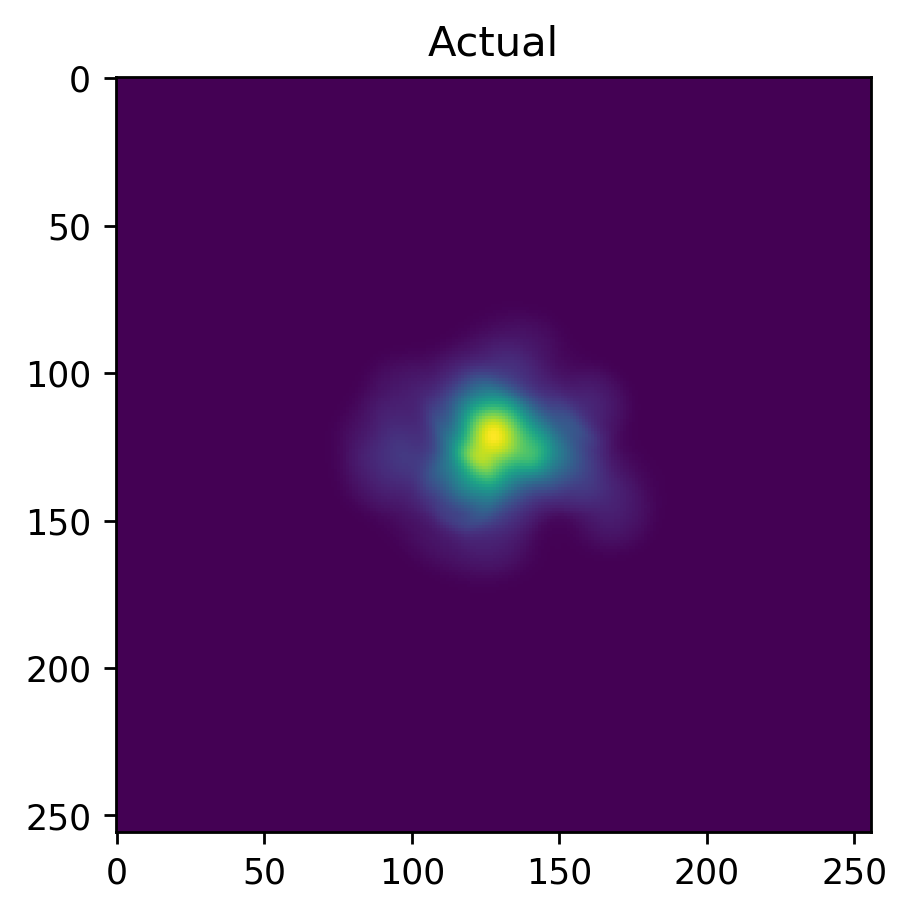

In [12]:
model.eval()
    
indices = [11]

sampler = SubsetSampler(indices)
loader = torch.utils.data.DataLoader(test_dataset,
                                     sampler=sampler)
fig = plt.figure(dpi=250)
fig.tight_layout()


(x, y) = next(iter(loader))

x_gpu = x.to(device)
prediction_gpu = model(x_gpu)
prediction = prediction_gpu.cpu().detach()

plt.title("Actual")
plt.imshow(torch.squeeze(y))
plt.savefig("../plots/actual.png")
'''
fig.add_subplot(3, count, counter + 2 * count + 1)
plt.title("actual")
plt.imshow(torch.squeeze(y))
plt.savefig('../plots/unet_adam_5ep.png')
'''

# ААА

In [6]:
class CernDataset23(Dataset):
    def __init__(self, folder):
        self.root_dir = folder
        self.paths = []
        
        for idx in os.listdir(folder):
            for jobresult in os.listdir(f'{folder}/{idx}'):
                if (os.path.exists(f'{folder}/{idx}/{jobresult}/printing_VISHNew/results/snapshot_Ed.dat') and
                        os.path.getsize(f'{folder}/{idx}/{jobresult}/printing_VISHNew/results/snapshot_Ed.dat') // 1048576 > 9):
                    self.paths.append(f'{idx}/{jobresult}')
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        sample_name = self.paths[index]
        sample_path = os.path.join(self.root_dir, sample_name)
        
        img = np.array([], dtype=np.float32)
        y = np.array([], dtype=np.float32)
        with open(f'{sample_path}/printing_VISHNew/results/snapshot_Ed.dat')as f:
            for idx, line in enumerate(f):
                if idx  > 262*2 and idx < 262 * 3:
                    t = np.fromstring(" ".join(line.split()), sep = ' ', dtype=np.float16)
                    img = np.hstack((img, t))
                if idx > 262 * 3 and idx < 262 * 4:
                    t = np.fromstring(" ".join(line.split()), sep = ' ', dtype=np.float16)
                    y = np.hstack((y, t))
        y_t = torch.from_numpy(y.reshape((1, 261, -1)))
        img_t = torch.from_numpy(img.reshape((1, 261, -1)))
        y_t = y_t[:, 3:-2, 3:-2]
        img_t = img_t[:, 3:-2, 3:-2]
        
        return img_t, y_t
    
        
        
dataset_23epoch = CernDataset23(train_folder)

In [7]:
batch_size = 8

data_size = len(dataset_23epoch)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset_23epoch, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset_23epoch, batch_size=batch_size,
                                         sampler=val_sampler)

In [10]:
import torch.optim as optim

model.to(device)

def unet_loss(output, target):
    loss = 0.5 * torch.sum(torch.abs(output - target)) / torch.sum(torch.abs(target))
    return loss

loss = unet_loss
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

compute_loss(model, val_loader)

0.20678095787155384